# Lesson 5: Analysing results

* Sanity Checks
* Evaluating experiment: Single Evaluation Metric, Multiple Evaluation Metrics
* Gotchas

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import norm, binom, binom_test

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = (10, 6)

# 1. Sanity Checks - invariant metrics
* Population sizing metrics  based on unit of diversion = Ensure that experiment and control populations are comparable
* Any other invariant metrics = Check whether invariance metrics did not change during experiment

### 1.1. Select Invariant metrics - based on unit of diversion!
<img src="images/lesson5_quiz_selecting_invariants.png">
<img src="images/lesson5_quiz_selecting_invariants_2.png">

### 1.2 Check invariant metrics - populations sizing

Bayesian approach

In [2]:
from scipy.stats import binom
test_split = (64454, 61818) # control, test
lower = binom.ppf(n=sum(test_split), p=0.5, q=0.025) 
upper = binom.ppf(n=sum(test_split), p=0.5, q=0.975)

In [3]:
test_split[1] / sum(test_split)

0.48956221490116575

In [4]:
lower, upper

(62788.0, 63484.0)

In [5]:
test_split[1]

61818

In [6]:
binom_test(test_split, p=0.5)

1.2113361931481954e-13

Frequentist approach

In [7]:
test_split = (15348, 15312) # control, test
test_split[0] / sum(test_split)

0.500587084148728

In [8]:
p = 0.5
z = 1.96
se = np.sqrt(p*(1-p)/sum(test_split))
print(se)

0.00285551160217


In [9]:
p - z * se, p + z * se

(0.49440319725975251, 0.50559680274024754)

### What to do if sanity checks failed

* Check technical set-up with engineers
* Retrospective analysis: try to reconstruct experiment diversion from previous data
* Pre-/post-period. If I saw same change in pre

Most common causes: 
* data capture
* experiment set-up
* infrastracture

Possibly not a learning effect if we see big changes/differences right from the beginning.

# 2. Evaluating experiment

## 2.1 Single evaluation metric

Goal: make business decision based on whether the experiment favorably affected the summary metric.

Analytically: decide if change in summary metric was statistically significant, also taking into cosideration magnitude and direction of change.


**Is significant check** 

Combine results of previous steps

* Characterising metrics, how it behaves (lesson 3)
* Variability estimation => how long to run the experiment (lesson 4)


**What if not significant?**

* Look into days of week, slice by groups etc. to better understand the response and find some possible bugs.
* Cross-check results of parametric vs. non-parametric (e.g. sign-test) 

#### Quiz 9 
https://classroom.udacity.com/courses/ud257/lessons/4085798776/concepts/40737188220923

In [10]:
# data
Xs_cont = np.array([196, 200, 200, 216, 212, 185, 225, 187, 205, 211, 192, 196, 223, 192])
Ns_cont = np.array([2029, 1991, 1951, 1985, 1973, 2021, 2041, 1980, 1951, 1988, 1977, 2019, 2035, 2007])

Xs_exp = np.array([179, 208, 205, 175, 191, 291, 278, 216, 225, 207, 205, 200, 297, 299])
Ns_exp = np.array([1971, 2009, 2049, 2015, 2027, 1979, 1959, 2020, 2049, 2012, 2023, 1981, 1965, 1993])

# meta
d_min = 0.01
alpha = 0.05
z = round(norm.ppf(1-alpha/2), 2)

size_empir = 5000
se_empir = 0.0062 # empricial Standard Error with 5000 in each group


dif = sum(Xs_exp) / sum(Ns_exp) - sum(Xs_cont)/sum(Ns_cont)
print(dif)

0.0116010196035


$\frac{\text{se empir}}{\text{scale empir}} = \frac{\text{SE}}{\text{scal experim}}$

In [11]:
scal_experim = np.sqrt(1 / sum(Ns_cont) + 1/sum(Ns_exp))
scal_empir = np.sqrt(1 / size_empir + 1/size_empir)
se = se_empir * scal_experim / scal_empir
se, se_empir

(0.002619982707795742, 0.0062)

In [12]:
effect_size = (dif - z * se, dif + z * se)
effect_size

(0.0064658534962369341, 0.016736185710796242)

In [13]:
Ps_cont = Xs_cont / Ns_cont
Ps_exp = Xs_exp / Ns_exp

In [14]:
# p_value of sign test
binom_test(x=sum(Ps_exp > Ps_cont), p=0.5, n=len(Ps_cont))

0.42395019531249989

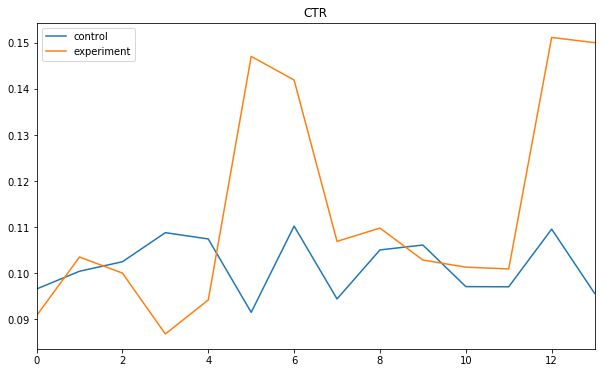

In [15]:
pd.Series(Ps_cont).plot(label='control')
pd.Series(Ps_exp).plot(label='experiment')
_ = plt.legend()
_ = plt.title('CTR')

In [16]:
control_share = Ns_cont / (Ns_cont + Ns_exp)
total = Ns_cont + Ns_exp

In [17]:
binom.ppf(n=total[0], p=control_share[0], q=0.975)

2091.0

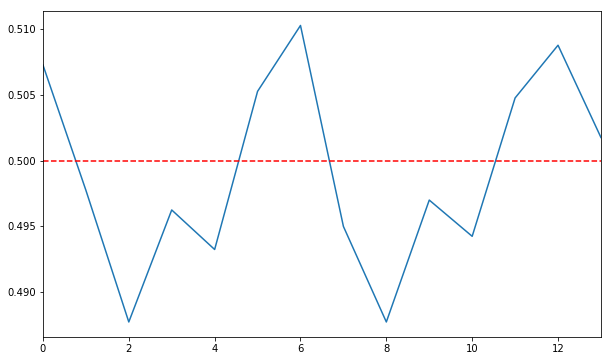

In [18]:
pd.Series(control_share).plot()
_ = plt.axhline(0.5, ls='--', color='red')

Recommendation: stop and understand why CTR is so much higher on the weekends

### Single Metric Gotchas: Simpoon's paradox
https://classroom.udacity.com/courses/ud257/lessons/4085798776/concepts/41091086150923

<img src="images/lesson5_simposons_paradox_ex.png">


In [19]:
# row: department A-B, columns men, women
applied = np.array([[825, 108],
                    [417, 375]])

accepted = np.array([[512, 89],
                     [137, 132]])

In [20]:
# acceptance rate per sex
accepted.sum(axis=0) / applied.sum(axis=0)

array([ 0.52254428,  0.45755694])

In [21]:
# acceptance rate per department
accepted.sum(axis=1) / applied.sum(axis=1)

array([ 0.64415863,  0.33964646])

In [22]:
# acceptance rate per department / sex
accepted / applied 

array([[ 0.62060606,  0.82407407],
       [ 0.32853717,  0.352     ]])

In [23]:
# share of men, women that applied to department a,b
applied / applied.sum(axis=0)

array([[ 0.66425121,  0.22360248],
       [ 0.33574879,  0.77639752]])

77% of women applied to department with lower overall acceptance rate (35%)

## 2.2 Multiple evaluation metrics

Testing more metrics, makes it more likely that one of them will show a statistically significant result by chance.
https://en.wikipedia.org/wiki/Multiple_comparisons_problem

Two main approaches:
* control for familywise error rate
* control for false discovery rate

 probability of at least one metric being statistically significant out of 10 tested at 95%, 99% confidence interval

In [24]:
# assuming independence between metrics
n = 10 # count null hypotheses
alpha1 = 0.95
alpha2 = 0.99
1 - alpha1**n, 1 - alpha2**n

(0.4012630607616213, 0.09561792499119559)

### Control familywise error rate (FWER)
https://en.wikipedia.org/wiki/Family-wise_error_rate

$\alpha_{familywise} = 1 - (1-\alpha_{individual})^m$ 

without independence assumption:

$\alpha_{familywise} = 1 - m \cdot \alpha_{individual}$

In [25]:
from multitesting_corr import p_multitest

### 1. Bonferroni correction 
https://en.wikipedia.org/wiki/Bonferroni_correction

* +simple
* +no assumptions
* -too conservative if metrics are not independent or there are many experiments => reduces statistical power

In [26]:
# metrics are assumed to be normally distributed
d_hat = np.array([0.03, -0.5, 0.01, 10])   # differences b/w test and control for each metric
se = np.array([0.013, 0.21, 0.0045, 6.85]) # standard errors

alpha_ind = 0.05
alpha_bonf = alpha_ind / len(d_hat)
z_ind = abs(norm.ppf(alpha_ind / 2)) # critical z-score
z_bonf = abs(norm.ppf(alpha_bonf / 2))

print(alpha_ind, alpha_bonf)
print(z_ind, z_bonf)
pvals = norm.pdf(d_hat / se)

0.05 0.0125
1.95996398454 2.49770547441


In [27]:
abs(d_hat / se) > z_ind

array([ True,  True,  True, False], dtype=bool)

In [28]:
abs(d_hat / se) > z_bonf

array([False, False, False, False], dtype=bool)

In [29]:
pvals_bonf = p_multitest(pvals, 'bonferroni')
pvals_bonf

{0.02343778879550024: 0.093751155182000959,
 0.027829451107324859: 0.11131780442929944,
 0.033773651035270635: 0.13509460414108254,
 0.13744582971982028: 0.54978331887928111}

### 2. Holm-Bonferroni Method
https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method

In [30]:
pvals_bonf = p_multitest(pvals, 'bonferroni')
pvals_holm = p_multitest(pvals, 'holm')
pvals_bonf = pd.DataFrame.from_dict(pvals_bonf, orient='index').sort_index()
pvals_holm = pd.DataFrame.from_dict(pvals_holm, orient='index').sort_index()
methods_comparis = pd.concat([pvals_bonf, pvals_holm], axis=1)
methods_comparis.columns = ['bonferroni', 'holm']

In [31]:
methods_comparis

,bonferroni,holm
0.023438,0.093751,0.093751
0.027829,0.111318,0.093751
0.033774,0.135095,0.093751
0.137446,0.549783,0.137446


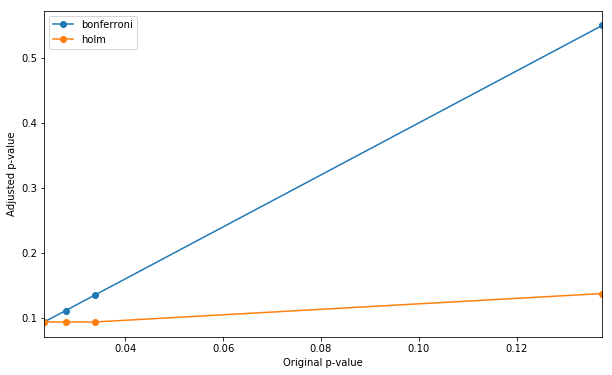

In [32]:
methods_comparis.plot(marker='o')
_ = plt.xlabel('Original p-value')
_ = plt.ylabel('Adjusted p-value')

Tests
http://www-stat.wharton.upenn.edu/~steele/Courses/956/Resource/MultipleComparision/Writght92.pdf

In [33]:
# Test 1
test_pvals = np.array([0.01, 0.04, 0.03, 0.005])
test_pvals_holm = p_multitest(test_pvals,'holm')
test_pvals_holm

{0.0050000000000000001: 0.02,
 0.01: 0.029999999999999999,
 0.029999999999999999: 0.059999999999999998,
 0.040000000000000001: 0.059999999999999998}

In [34]:
### Test 2
test_pvals = np.array([0.00294, 0.00668, 0.06940, 0.13903, 0.13903, 0.70222])
test_pvals_bonf = p_multitest(test_pvals,'bonferroni')
test_pvals_bonf

{0.0029399999999999999: 0.017639999999999999,
 0.0066800000000000002: 0.040080000000000005,
 0.069400000000000003: 0.41639999999999999,
 0.13902999999999999: 0.83417999999999992,
 0.70221999999999996: 1}

In [35]:
### Test 2
test_pvals_holm = p_multitest(test_pvals,'holm')
test_pvals_holm

{0.0029399999999999999: 0.017639999999999999,
 0.0066800000000000002: 0.033399999999999999,
 0.069400000000000003: 0.27760000000000001,
 0.13902999999999999: 0.41708999999999996,
 0.70221999999999996: 0.70221999999999996}

In [36]:
### Test 3
test_pvals_fdr = p_multitest(test_pvals, 'fdr')
test_pvals_fdr

{0.0029399999999999999: 0.017639999999999999,
 0.0066800000000000002: 0.020040000000000002,
 0.069400000000000003: 0.13880000000000001,
 0.13902999999999999: 0.16683599999999998,
 0.70221999999999996: 0.70221999999999996}

In [37]:
pvals_bonf = pd.DataFrame.from_dict(test_pvals_bonf, orient='index').sort_index()
pvals_holm = pd.DataFrame.from_dict(test_pvals_holm, orient='index').sort_index()
pvals_fdr = pd.DataFrame.from_dict(test_pvals_fdr, orient='index').sort_index()
methods_comparis = pd.concat([pvals_bonf, pvals_holm, pvals_fdr], axis=1)
methods_comparis.columns = ['bonferroni', 'holm', 'fdr']

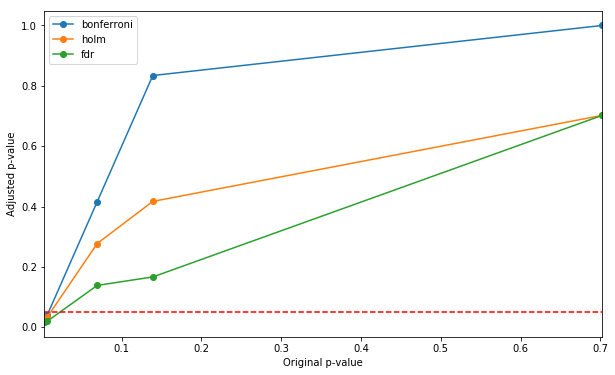

In [38]:
alpha = 0.05
methods_comparis.plot(marker='o')
_ = plt.axhline(alpha, color='red', ls='--')
_ = plt.xlabel('Original p-value')
_ = plt.ylabel('Adjusted p-value')

### 3. Resampling procedures